# Evaluate VADER on Control Data

In [2]:
import sys
sys.path.append("C:/Users/jadea/source/repos/functions to import M2 thesis")
from commented_code_M2_thesis import get_AE_prediction_dict

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from commented_code_M2_thesis import remove_stop_words2
#from commented_code_M2_thesis import split_and_join_sentences

In [4]:
aspect_keywords_main_compare = {'food and beverages': ['food', 'beverage', 'meal', 'snack'],
 'entertainment': ['entertainment',
  'movie',
  'screen',
  'wifi',
  'headphone',
  'TV',
  'music',
  'IFE',
  'video',
  'internet',
  'wi-fi',
  'connectivity'],
'on ground services': [
        'check-in', 'lounge', 'counter', 'luggage', 'ground staff', 'ground crew', 'check in', 'gate'
    ],
 'delay': ['delay', 'late', 'punctuality'],
 'crew flight': ['attendant', 'steward', 'FA', 'crew', 'hostess', 'staff'],
 'seat comfort': ['legroom', 'armrest', 'recline', 'width', 'seat']}

In [150]:
data = pd.read_csv('C:/Users/jadea/Notebooks/Mémoire M2 notebooks/skytrax_control.csv')
#data.drop(columns='Unnamed: 0', inplace=True)
data.columns = ['Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date',
       'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money', 'Recommended', 'origin',
       'destination', 'Index']
data_airline = data[data['Airline Name'].isin(['American Airlines','Spirit Airlines', 'United Airlines'])]

##### all control data

In [1]:
import pickle
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/pred_sentences_link_reviews_control.pkl", 'rb') as f:
    pred_sentences_link_reviews = pickle.load(f)
with open("C:/Users/jadea/Notebooks/Mémoire M2 notebooks/AE_pred_label_control.pkl", 'rb') as f:
    AE_pred_label = pickle.load(f)

In [2]:
#number of reviews per aspects in control data 
for aspect in ['seat comfort', 'entertainment', 'crew flight', 'food and beverages', 'on ground services']:
    print(aspect, len((list(pred_sentences_link_reviews[aspect].values()))))

seat comfort 3486
entertainment 2174
crew flight 6313
food and beverages 3124
on ground services 3288


##### bipolar (control) data

In [189]:
full_test_set_2 = data_airline #control data

import math
def distance_aspect_to_mean(row, aspect, aspects):
    if row[aspect] is not None:
        diff = row[aspect]-row[aspects].mean()
        return abs(diff)
    else:
        return np.nan

aspect = 'seat comfort'
all_aspects = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money']
aspects_to_pred = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment']
aspect_thresholds = [1.2, 1.43, 1.29, 1.33, 1.6]
aspect_threshold = 1.6

full_test_set_2_copy = full_test_set_2.copy()
full_test_set_2_copy = full_test_set_2_copy[~full_test_set_2_copy[aspect].isna()]

full_test_set_2_copy['dist_{}'.format(aspect)] = full_test_set_2_copy.apply(lambda x: distance_aspect_to_mean(x, aspect, all_aspects), axis=1)                                                                            
index_bipolar = full_test_set_2_copy[full_test_set_2_copy['dist_{}'.format(aspect)] > aspect_threshold]['Index']
print(len(index_bipolar))

full_test_set_bipolar = full_test_set_2_copy[full_test_set_2_copy['Index'].isin(index_bipolar)]
full_test_set_bipolar = full_test_set_bipolar.sample(frac=1)
print(len(full_test_set_bipolar))
                                                                           
index_unipolar = full_test_set_2_copy[full_test_set_2_copy['dist_{}'.format(aspect)] <= aspect_threshold]['Index']
#print(len(index_unipolar))

full_test_set_unipolar = full_test_set_2_copy[full_test_set_2_copy['Index'].isin(index_unipolar)]
full_test_set_unipolar = full_test_set_unipolar.sample(frac=0.5)
#print(len(full_test_set_unipolar))

#full_test_set_all = full_test_set_2_copy.sample(1000)
print(len(full_test_set_2_copy))
#full_test_set_all = pd.concat([full_test_set_unipolar, full_test_set_bipolar])

35
35
1334


In [190]:
#aspect = 'food and beverages' 
pred_sentences_link_reviews, AE_pred_label = get_AE_prediction_dict(full_test_set_2_copy, aspect, aspect_keywords_main_compare, skytrax_labels=True)#, real_labels=real_labels_all)


started
ended


#### Compute VADER predictions

In [191]:
#aspect = 'seat comfort' #need to precise only if not using bipolar data
testing_sentences = []
testing_labels = []
for key, value in AE_pred_label[aspect].items():
    testing_sentences.append(key)
    testing_labels.append(value)

In [192]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_list_of_sentences_vader(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = {}
            
    for sentence in sentences:
        sentiment_score = analyzer.polarity_scores(sentence)
        results[sentence] = sentiment_score['compound']
    
    return results

In [194]:
vader_result = analyze_list_of_sentences_vader(testing_sentences)
vader_result

{'United flies the lovely new 787 on this route, the air quality is better, the lighting is better and the seats, although they look really small, are actually amongst the most comfortable I have flown on.': 0.9432,
 'When attempting to check-in online, the website will give you the option to sign up for membership for $9 so that you pay less for your luggages/seats.': -0.1689,
 'They charged me for a middle seat (never had to this before).': -0.2023,
 'The seats were tight and did not recline (new experience).': 0.0,
 "Overall I paid more for this flight than a direct flight where I could've watched a movie on my reclining seat and getting served water/tea/coffee.": 0.0,
 'On the TPA-DEN and DEN-IAD flights I had the forward, over-wing exit row window, with the middle seat unoccupied.': 0.0,
 'On the IAD-TPA segment, the whole exit row was open, but I was upgraded to an aisle seat in first class.': 0.0,
 'This experience confirmed for me that the exit row seats are the best in the pla

#### Evaluate VADER performance
(see below for evaluation with best/custom threshold for a specific aspect)

In [195]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support, f1_score

def evaluate_sentiment_classification_vader(data, aspect, result, pred_sentences_link_reviews, skytrax_labels = True, real_labels=None, threshold=0):

    if skytrax_labels == True:
        real_labels = data
    
    predicted_labels_vader = list(result.values())
    sentences_vader = list(result.keys())

    #link each prediction to the index. Group together the predictions for every index (in case several sentences from a same review)
    #average them, compare to true labels
    
    test_link_dict = {}
    for enum, prediction in enumerate(predicted_labels_vader):
        index = pred_sentences_link_reviews[aspect][sentences_vader[enum]]
        if index in test_link_dict.keys():
            test_link_dict[index].append(prediction)
        else:
            test_link_dict[index] =  [prediction]

    # Keep only test_link_dict keys where data[data['Index'] == key][aspect] is not NaN
    filtered_test_link_dict = {}
    for key, value in test_link_dict.items():
        if not pd.isna(real_labels[real_labels['Index'] == key][aspect].values[0]):
            filtered_test_link_dict[key] = value
    test_link_dict = filtered_test_link_dict
    print(test_link_dict)
    
    #predictions
    test_final_pred_dict = {}
    for key in test_link_dict.keys():
        test_final_pred_dict[key] = np.mean(test_link_dict[key])
    test_final_pred_df = pd.DataFrame.from_dict(test_final_pred_dict, orient='index', columns=['proba_1']).reset_index()
    test_final_pred_df.rename(columns={'index': 'Index'}, inplace=True)
    test_final_pred_df['pred']=np.where(test_final_pred_df['proba_1']<=threshold, 0, 1)

    
    #true labels
    list_indices = [key for key in test_link_dict.keys()]
    
    if skytrax_labels == True:
        df_true_labels = data[data['Index'].isin(list_indices)][['Index', aspect]]
        df_true_labels = df_true_labels.dropna(subset=aspect)
        df_true_labels[aspect] = np.where(df_true_labels[aspect]<=3, 0, 1)
        df_true_labels 
    else:
        df_true_labels = real_labels[real_labels['Index'].isin(list_indices)][['Index', aspect]]
        df_true_labels[aspect] = np.where(df_true_labels[aspect]=='POS', 1, 0)


    df_calc_score = df_true_labels.merge(test_final_pred_df, on='Index')
    df_calc_score
    accuracy = (df_calc_score[aspect] == df_calc_score['pred']).mean()
    F1_score = f1_score(df_calc_score[aspect], df_calc_score['pred'])

    
    # Calculate precision, recall for each class (positive and negative)
    precision, recall, f1, support = precision_recall_fscore_support(df_calc_score[aspect], df_calc_score['pred'], average=None, labels=[0, 1])
    _, _, f1_macro, _ = precision_recall_fscore_support(df_calc_score[aspect], df_calc_score['pred'], average='macro', labels=[0, 1])
    
    # Display the results
    print(f'Accuracy: {accuracy:.3f}')
    print(f'F1 Score: {F1_score:.3f}')
    print(f'Precision (Negative): {precision[0]:.3f}')
    print(f'Recall (Negative): {recall[0]:.3f}')
    print(f'F1 Score (Negative): {f1[0]:.3f}')
    print(f'Precision (Positive): {precision[1]:.3f}')
    print(f'Recall (Positive): {recall[1]:.3f}')
    print(f'F1 Score (Positive): {f1[1]:.3f}')
    print(f'F1 Score (Macro): {f1_macro:.3f}')


    ConfusionMatrixDisplay.from_predictions(df_calc_score[aspect], df_calc_score['pred'], normalize='true', cmap='Blues')
    plt.title('{}, normalized on true labels'.format(aspect))
    plt.show()
    ConfusionMatrixDisplay.from_predictions(df_calc_score[aspect], df_calc_score['pred'], normalize='pred', cmap='Reds')
    plt.title('{}, normalized on predicted labels'.format(aspect))
    plt.show()

    return accuracy, df_calc_score


{19582: [0.9432], 30853: [-0.1689, -0.2023, 0.0, 0.0], 19245: [0.0, 0.0, 0.6369], 30908: [0.1779, -0.6436], 97916: [0.6249, 0.0], 29216: [-0.128], 16623: [-0.2755, -0.0426], 29144: [0.8313], 20671: [0.5563], 94289: [-0.5267], 31174: [0.7184, 0.0], 17619: [0.0, 0.0516, 0.0, 0.0772, 0.0], 30113: [-0.4215], 19632: [0.0], 30011: [0.0, -0.1027], 18200: [0.0, -0.34, 0.3612], 27871: [0.0], 28634: [-0.0516, 0.0], 20276: [0.4939, -0.4794], 96796: [0.34, 0.0, 0.3182, -0.0258, 0.6705, -0.0258, -0.8802], 21060: [-0.6249, 0.2023, 0.0, -0.2263, 0.0, 0.0], 20204: [0.0, 0.7351], 28276: [-0.6447], 28574: [0.743, 0.4939], 27099: [0.4588], 16835: [0.8313, 0.8176, 0.0], 19852: [0.0, 0.0, -0.4391], 95693: [0.0, 0.0], 97572: [-0.25], 99211: [0.0], 97224: [0.0, 0.0, 0.0, -0.296, 0.7227, 0.4939], 30429: [0.0], 19544: [-0.3089], 95655: [0.4215], 29284: [-0.4391, -0.1761, 0.0], 31773: [-0.2023, 0.0], 95855: [0.0, 0.3724], 19133: [0.0, -0.8202], 99508: [-0.6436], 99223: [0.0], 97182: [-0.296], 16385: [0.4767, 0.

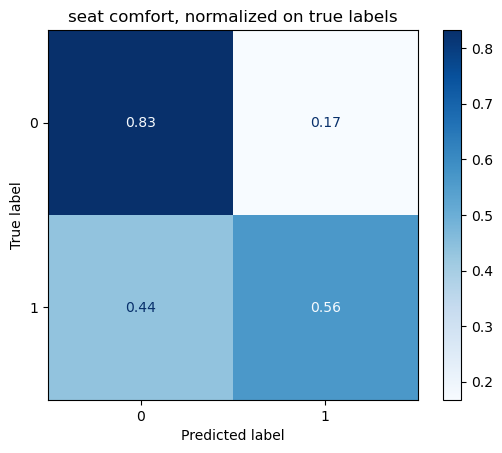

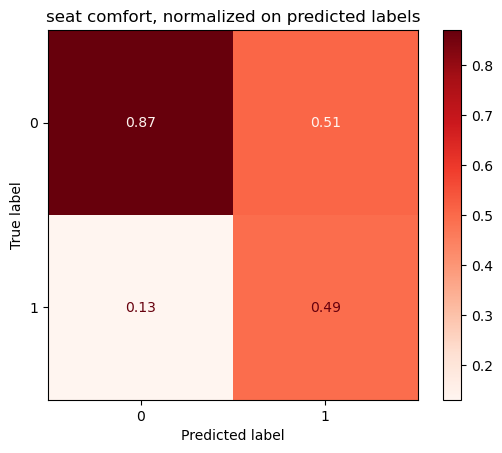

In [196]:
_, df_calc_scores = evaluate_sentiment_classification_vader(full_test_set_2_copy, aspect, vader_result, pred_sentences_link_reviews, skytrax_labels = True, real_labels=None, threshold=0.24)

To create result table for all aspects, iterate the code above on all aspects and run the code below after each iteration:

In [ ]:
#run only once, after the 1st iteration
df_airline = pd.DataFrame()
for aspect in ['crew flight', 'food and beverages', 'on ground services', 'entertainment', 'seat comfort']:
    df_airline[aspect]=0
df_airline

In [197]:
#run after each iteration

#aspect = 'entertainment'
df_airline.at['predicted satisfaction', aspect] = df_calc_scores.mean(axis=0)['pred']
df_airline.at['real satisfaction', aspect] = df_calc_scores.mean(axis=0)[aspect]
df_airline.at['real insatisfaction', aspect] = 1-df_calc_scores.mean(axis=0)[aspect]
df_airline.at['predicted insatisfaction', aspect] = 1-df_calc_scores.mean(axis=0)['pred']
df_airline

,crew flight,food and beverages,on ground services,entertainment,seat comfort
predicted satisfaction,0.262722,0.286245,0.147287,0.354978,0.256198
real satisfaction,0.234320,0.171004,0.127907,0.233766,0.223140
real insatisfaction,0.765680,0.828996,0.872093,0.766234,0.776860
predicted insatisfaction,0.737278,0.713755,0.852713,0.645022,0.743802


For evaluation with best threshold: You can select a custom probability threshold in evaluate_sentiment_classification_vader.

In [ ]:
# import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import warnings

warnings.filterwarnings("ignore")

# Assuming df_calc_scores['proba_1'] contains the predicted probabilities for class 1
# and df_calc_scores[aspect] contains the true labels (0 or 1)

# Get the unique sorted probabilities from the predictions
thresholds = np.sort(df_calc_scores['proba_1'].unique())

best_threshold = 0.0
best_f1_score = 0.0
best_interval_start = 0.0
best_interval_end = 0.0

for i, threshold in enumerate(thresholds):
    # Apply the threshold to get binary predictions
    preds = (df_calc_scores['proba_1'] >= threshold).astype(int)
    
    # Calculate precision, recall, and F1 score for this threshold
    precision, recall, f1, _ = precision_recall_fscore_support(df_calc_scores[aspect], preds, average='macro')
    
    # Check if this F1 score matches the current best F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold
        best_interval_start = threshold
        best_interval_end = threshold
    elif f1 == best_f1_score:
        # Extend the interval if the F1 score matches the best one found so far
        best_interval_end = threshold

# Calculate the mean of the best threshold interval
mean_best_threshold = (best_interval_start + best_interval_end) / 2

# Output the best threshold, interval, and mean
print(f'Best Threshold Interval: [{best_interval_start:.6f}, {best_interval_end:.6f}]')
print(f'Mean of Best Threshold Interval: {mean_best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.6f}')
threshold = mean_best_threshold
print(threshold)

{87026: [-0.2263, 0.0], 62433: [0.0], 37923: [0.8176], 66488: [-0.1591], 39771: [0.7232], 19582: [0.0], 103664: [0.5859], 102652: [-0.6808, -0.6249], 31950: [0.0], 59133: [0.0], 40452: [0.0, 0.5984, -0.3089], 88107: [-0.7351, -0.5719], 72404: [0.6705], 49281: [-0.4215], 70571: [0.908], 72728: [0.7783], 19853: [-0.4822], 52670: [-0.6597], 91620: [-0.5709], 84612: [0.6124], 23389: [0.0], 42619: [-0.7353], 39384: [0.9485], 1022: [-0.0258], 3289: [-0.2914, 0.2023], 51909: [0.0, 0.0], 61261: [0.6249], 85770: [0.0, 0.3612, 0.6055, -0.0286, 0.6249, 0.7684], 65989: [0.0], 56038: [0.4404], 37971: [0.7269], 36184: [0.743], 79808: [-0.4767, 0.1603], 80395: [-0.4201, 0.0, -0.4215], 66432: [0.0, 0.4019], 21377: [0.0], 11022: [-0.476], 51017: [-0.6886], 37960: [0.0, -0.5423, 0.0], 62146: [0.4019, 0.3477, -0.2023], 55359: [-0.3089, 0.4019, 0.0], 1701: [-0.2732], 56965: [0.7391], 38032: [0.0, 0.5106], 15176: [-0.5407], 74479: [0.0, 0.9118], 49727: [0.0], 109395: [0.8271], 16623: [0.1779], 85853: [0.57

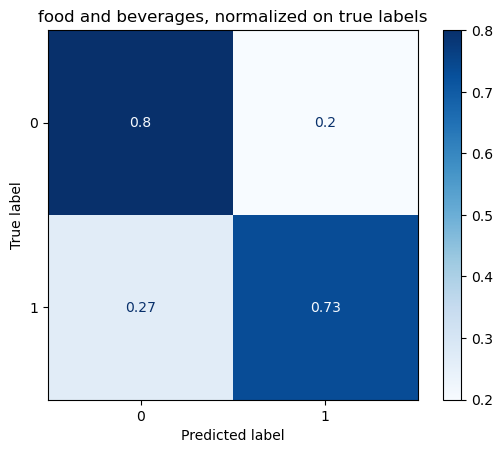

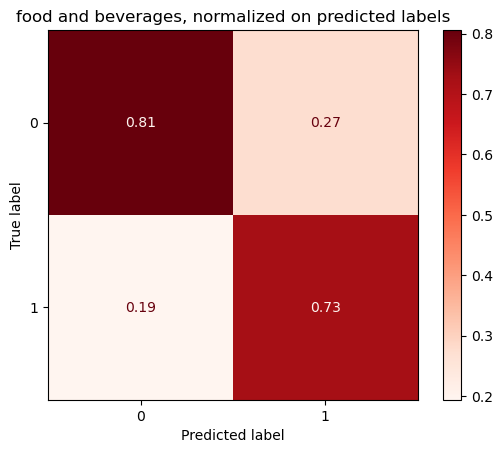

In [35]:
#Evaluation with best threshold
#aspect='crew flight'
_, df_calc_scores = evaluate_sentiment_classification_vader(full_test_set_2_copy, aspect, vader_result, pred_sentences_link_reviews, skytrax_labels = True, real_labels=None, threshold=threshold)